Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from causal_tree import CausalTree
from sklearn.tree import DecisionTreeClassifier
import time

#df = pd.read_csv("../../data/criteo-uplift-v2.1.csv")
#df = df.sample(frac=0.1, random_state=42)
df = pd.read_csv("testdata.csv")

Split the data into training and test.

In [2]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
all_features = df.columns.values[:12].tolist()

Build and tune the non-causal tree.

In [3]:
from sklearn.tree import DecisionTreeClassifier

# Get training data to build and tune the model
untreated = df_train.treatment == 0
X_train = df_train.loc[untreated, all_features]
y_train = df_train.conversion[untreated]

# Build and tune model
tuned_parameters = [{'min_samples_leaf': [2000, 4000, 8000, 16000, 32000]}]
algorithm = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(algorithm, tuned_parameters, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("Best complexity parameter found for the non-causal model:")
print(grid_tree.best_params_)
untreated_tree = grid_tree.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best complexity parameter found for the non-causal model:
{'min_samples_leaf': 4000}


Build and tune causal tree.

In [4]:
# Get training data to build and tune the model
X_train = df_train[all_features + ['treatment']].rename(columns={"treatment":"treated"})
y_train = df_train.conversion
#tuned_parameters = [{'min_samples_leaf': [2000, 4000, 8000, 16000, 32000]}]
tuned_parameters = [{'min_samples_leaf': [32000]}]
grid_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5, verbose=10, n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(grid_tree.best_params_)
causal_tree = grid_tree.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
ENTER CINIT
Best parameters set found on development set:
{'min_samples_leaf': 32000}


In [5]:
causal_tree.criterion.set_treated(X_train.treated.values.astype(np.int32))

Get predictions in the test set.

In [6]:
X_test_causal = df_test[all_features + ['treatment']].rename(columns={"treatment":"treated"})
X_test_noncausal = df_test[all_features]

pred_un = untreated_tree.predict_proba(X_test_noncausal)[:, 1]
pred_up = causal_tree.predict(X_test_causal)

Plot uplift curves in the test set.

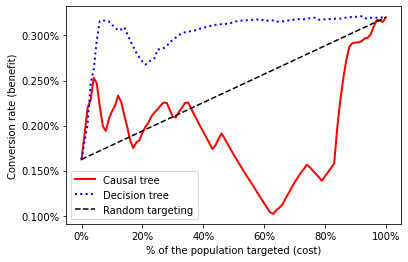

In [7]:
step_size = 0.01
percentage_targeted = np.arange(1 + step_size, step=step_size)

def plot_uplift_curve(preds, baseline, label, color, linestyle=None):
    
    uplift = [baseline]
    rank_order = (-preds).argsort()
    test_size = df_test.shape[0]
    y_test = df_test.conversion
    t_test = df_test.treatment == 1
    for per_size in percentage_targeted[1:]:
        target_size = int(test_size * per_size)
        t_targeted = t_test.iloc[rank_order[:target_size]]
        y_targeted = y_test.iloc[rank_order[:target_size]]
        effect_on_targeted = y_targeted[t_targeted == 1].mean() - y_targeted[t_targeted == 0].mean()
        conversion_rate = effect_on_targeted * per_size + baseline
        uplift.append(conversion_rate)
    # Plot results
    ax = plt.plot(percentage_targeted, uplift, label=label, color=color, linewidth=2, linestyle=linestyle)[0]
    
baseline_none = df_test.conversion[df_test.treatment == 0].mean()
baseline_all = df_test.conversion[df_test.treatment == 1].mean()
# Plot competing models
plot_uplift_curve(pred_up, baseline_none, "Causal tree", color='red')
plot_uplift_curve(pred_un, baseline_none, "Decision tree", color='blue', linestyle=':')
# Plot random targeting
plt.plot([0, 1], [baseline_none, baseline_all], '--', color='black', label="Random targeting")[0]
plt.ylabel("Conversion rate (benefit)")
plt.xlabel("% of the population targeted (cost)")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
#plt.savefig('uplift_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
### IMPORTS
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from causal_tree import CausalTree
from sklearn.tree import DecisionTreeClassifier
import time

### LOAD DATA
print("Load data")
df = pd.read_csv("../../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)

### SPLIT DATA
print("Split data")
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
all_features = df.columns.values[:12].tolist()

### BUILD AND TUNE NON-CAUSAL TREE
print("Fit and tune non-causal tree")
# Get training data to build and tune the model
untreated = df_train.treatment == 0
X_train = df_train.loc[untreated, all_features]
y_train = df_train.conversion[untreated]
# Build and tune model
tuned_parameters = [{'min_samples_leaf': [2000, 4000, 8000, 16000, 32000]}]
algorithm = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(algorithm, tuned_parameters, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("Best complexity parameter found for the non-causal model:")
print(grid_tree.best_params_)
untreated_tree = grid_tree.best_estimator_

### BUILD AND TUNE CAUSAL TREE
print("Fit and tune causal tree")
# Get training data to build and tune the model
X_train = df_train[all_features + ['treatment']].rename(columns={"treatment":"treated"})
y_train = df_train.visit
# Build and tune model
tuned_parameters = [{'min_samples_leaf': [2000, 4000, 8000, 16000, 32000]}]
grid_tree = GridSearchCV(CausalTree(random_state=42), tuned_parameters, cv=5, verbose=10, n_jobs=-1)
grid_tree.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(grid_tree.best_params_)
causal_tree = grid_tree.best_estimator_

### PREDICT IN THE TEST SET
print("Predict in the test set")
X_test_causal = df_test[all_features + ['treatment']].rename(columns={"treatment":"treated"})
X_test_noncausal = df_test[all_features]
pred_un = untreated_tree.predict_proba(X_test_noncausal)[:, 1]
pred_up = causal_tree.predict(X_test_causal)

### PLOT UPLIFT CURVES
print("Plot uplift curves")
step_size = 0.01
percentage_targeted = np.arange(1 + step_size, step=step_size)

def plot_uplift_curve(preds, baseline, label, color, linestyle=None):
    
    uplift = [baseline]
    rank_order = (-preds).argsort()
    test_size = df_test.shape[0]
    y_test = df_test.conversion
    t_test = df_test.treatment == 1
    for per_size in percentage_targeted[1:]:
        target_size = int(test_size * per_size)
        t_targeted = t_test.iloc[rank_order[:target_size]]
        y_targeted = y_test.iloc[rank_order[:target_size]]
        effect_on_targeted = y_targeted[t_targeted == 1].mean() - y_targeted[t_targeted == 0].mean()
        conversion_rate = effect_on_targeted * per_size + baseline
        uplift.append(conversion_rate)
    # Plot results
    ax = plt.plot(percentage_targeted, uplift, label=label, color=color, linewidth=2, linestyle=linestyle)[0]
    
baseline_none = df_test.conversion[df_test.treatment == 0].mean()
baseline_all = df_test.conversion[df_test.treatment == 1].mean()
# Plot competing models
plot_uplift_curve(pred_up, baseline_none, "Causal tree", color='red')
plot_uplift_curve(pred_un, baseline_none, "Decision tree", color='blue', linestyle=':')
# Plot random targeting
plt.plot([0, 1], [baseline_none, baseline_all], '--', color='black', label="Random targeting")[0]
plt.ylabel("Conversion rate (benefit)")
plt.xlabel("% of the population targeted (cost)")
plt.legend()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=3))
#plt.savefig('../results/uplift_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Load data
Split data
Fit and tune non-causal tree
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best complexity parameter found for the non-causal model:
{'min_samples_leaf': 8000}
Fit and tune causal tree
Fitting 5 folds for each of 5 candidates, totalling 25 fits
